In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

In [2]:
#import seaborn as sns
import dictys
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'
input_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'

## Plot cell state distributions per fate

In [ ]:
# load cell_count_per_window_df from csv file
cell_count_per_window_df = pd.read_csv(os.path.join(input_folder, 'cell_count_per_window_df.csv'), header=0, index_col=0)
day_count_per_window_df = pd.read_csv(os.path.join(input_folder, 'day_count_per_window_df.csv'), header=0, index_col=0)
pseudotime_values_of_windows = pd.read_csv(os.path.join(input_folder, 'pseudotime_values_of_windows.csv'), header=None)[0].tolist()
cell_count_per_window_df.columns = cell_count_per_window_df.columns.astype(int)
day_count_per_window_df.columns = day_count_per_window_df.columns.astype(int)

In [ ]:
# assign window indices to bifurcation branches
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}
colors_day_count = {
    'day0_2': '#87CEFA',     # lightskyblue
    'day3_4': '#1E90FF',     # dodgerblue
    'day5_6': '#00008B'
}

In [ ]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = cell_count_per_window_df[PB_post_bifurcation_window_indices]
#remove ActB-1 from the dataframe rows
df_plot = df_plot.drop(index=['ActB-1', 'earlyActB'])


In [ ]:
import numpy as np

# Create time bins
n_bins = 8  # Adjust this number as needed
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]
x_min, x_max = min(x), max(x)

# Create bin edges
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]

# Initialize binned data and count time points per bin
binned_data = {state: [0] * n_bins for state in df_plot.index}
bin_counts = [0] * n_bins  # Track how many time points are in each bin

# Aggregate data into bins
for i, time_point in enumerate(x):
    # Find which bin this time point belongs to
    bin_idx = np.digitize(time_point, bin_edges) - 1
    bin_idx = max(0, min(bin_idx, n_bins - 1))  # Ensure within bounds
    
    # Add counts for each cell state to the appropriate bin
    for state in df_plot.index:
        binned_data[state][bin_idx] += df_plot.loc[state].values[i]
    
    bin_counts[bin_idx] += 1

# Average the counts within each bin (so each bin represents average composition)
for state in df_plot.index:
    for bin_idx in range(n_bins):
        if bin_counts[bin_idx] > 0:
            binned_data[state][bin_idx] = binned_data[state][bin_idx] / bin_counts[bin_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.grid(False)

# Initialize bottom array for stacking
bottom = [0] * n_bins

# Plot each cell state as a layer in the stacked bar
for state in df_plot.index:
    y = binned_data[state]
    plt.bar(range(n_bins), y,
            label=state,
            color=colors_cell_count[state],
            bottom=bottom,
            alpha=0.8)
    
    # Update bottom for next stack layer
    bottom = [bottom[i] + y[i] for i in range(n_bins)]

plt.xlabel('Binned windows (PB branch)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Average Cell Count', fontsize=14, fontweight='bold')
plt.xticks(range(n_bins), [f"Bin {i+1}" for i in range(n_bins)], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print bin info for verification
print("Time points per bin:", bin_counts)
print("Total cells per bin:", [sum(binned_data[state][i] for state in df_plot.index) for i in range(n_bins)])

In [ ]:
import matplotlib.pyplot as plt

# Extract the day5_6 data for PB and GC windows
pb_indices = PB_post_bifurcation_window_indices
gc_indices = GC_post_bifurcation_window_indices

pb_pseudotime = [pseudotime_values_of_windows[i] for i in pb_indices]
gc_pseudotime = [pseudotime_values_of_windows[i] for i in gc_indices]

pb_day5_6 = day_count_per_window_df.loc['day5_6', pb_indices]
gc_day5_6 = day_count_per_window_df.loc['day5_6', gc_indices]

plt.figure(figsize=(12, 6))

# Plot PB branch
plt.plot(pb_pseudotime, pb_day5_6, label='PB branch cells', color='#BB3636', linewidth=2)
plt.fill_between(pb_pseudotime, pb_day5_6, color='#BB3636', alpha=0.25)

# Plot GC branch
plt.plot(gc_pseudotime, gc_day5_6, label='GC branch cells', color='#008000', linewidth=2)
plt.fill_between(gc_pseudotime, gc_day5_6, color='#008000', alpha=0.25)

plt.xlabel('Pseudotime')
plt.ylabel('Day 5 to 6 Cell Counts')
plt.legend()
plt.tight_layout()
plt.show()

# Enriched regulons from static + dynamic GRN analysis and plotting

In [4]:
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

KeyboardInterrupt: 

### Load static enriched link as per state

In [ ]:
#Red = PB, Blue = GC
state_LF_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/gene_colors.csv'
enriched_links_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/SLIDE_LF_enrichment/SLIDE_LF_enriched_1_TFs_7_3_GC_PB.csv'
# store the state_LF in a df
state_LF = pd.read_csv(state_LF_file)
enriched_links = pd.read_csv(enriched_links_file)

In [ ]:
def create_enriched_links_per_state(enriched_links, state_LF):
    # Create dictionaries to map genes to their states
    gene_to_state = dict(zip(state_LF['gene'], state_LF['color']))

    # Initialize lists to store links for each state
    state1_links = []  # For Red (PB)
    state2_links = []  # For Blue (GC)
    TFs = set()
    targets_in_lf = set()

    # Iterate over each row in the enriched_links DataFrame
    for _, row in enriched_links.iterrows():
        tf_str = row['TF']
        # Extract the TF name from the string representation of a tuple
        tf = tf_str.strip("(,)' ").replace("'", "")
        TFs.add(tf)
        
        # Handle the targets as a string representation of a list
        if isinstance(row['common'], str):
            # If it's a string representation of a list, convert it to a list
            targets_str = row['common'].strip("[]").replace("'", "")
            targets = [t.strip() for t in targets_str.split(",")]
        else:
            # If it's already a list
            targets = row['common']
    
        # Assign each TF-target pair to the appropriate state
        for target in targets:
            if target and target in gene_to_state:
                targets_in_lf.add(target)
                state = gene_to_state[target]
                link = (tf, target)
                if state == 'Red':
                    state1_links.append(link)
                elif state == 'Blue':
                    state2_links.append(link)
    TFs = list(TFs)
    targets_in_lf = list(targets_in_lf)

    return state1_links, state2_links, TFs, targets_in_lf

In [ ]:
PB_links, GC_links, TFs, targets_in_lf = create_enriched_links_per_state(enriched_links, state_LF)

In [ ]:
# filter the TFs that are not in the dynamic object
TF_indices, _, missing_tfs = get_tf_indices(dictys_dynamic_object, TFs)
# Remove items that are not in the dynamic object
filtered_TFs = [item for item in TFs if item not in missing_tfs]

#update the GC_links and PB_links
GC_links = [link for link in GC_links if link[0] in filtered_TFs]
PB_links = [link for link in PB_links if link[0] in filtered_TFs]


In [ ]:
PB_links_plotting = [('BACH2','XBP1'),('RUNX2','PRDM1'),('CREB3L2','RUNX2'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('CREB3L2','MZB1'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('PRDM1','IRF4'),('IRF4','ELL2'),('XBP1','PPIB'),('XBP1','TXNDC11'),('XBP1','HSP90B1'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [ ]:
GC_links_plotting = [('ARID5B','PIKFYVE'),('ARID5B','PDE4D'),('IRF4','PAX5'),('NFKB1','PAX5'),('IRF4','AFF3'),('NFKB1','AFF3'),('BATF','PPIB'),('BACH2','MZB1'),('PAX5','GLCCI1'),
                     ('PAX5','PRDM1'),('CREB3L2','PAX5')]

In [ ]:
PRDM1_links = custom_tf_links = [('PRDM1', 'CYB561A3'),('PRDM1', 'SPIB'),('PRDM1','CNPY3'),('PRDM1','TGFB1'),('PRDM1','FUT8'),('PRDM1','BABAM1'),('PRDM1','PNISR'),('PRDM1','BCAP31'),('PRDM1','FOXJ3'),('PRDM1','RBM38'),('PRDM1','NT5C'),('PRDM1','OCIAD1'),('PRDM1','NDUFB5'),('PRDM1','AIP'),('PRDM1','VAPA'),('PRDM1','LZIC'),('PRDM1','TMEM248'),('PRDM1','NAA38'),('PRDM1','EMC3'),('PRDM1','NSUN5'),('PRDM1','NIBAN3'),('PRDM1','STX7'),('PRDM1','MYBL2'),('PRDM1','PVT1'),('PRDM1','ARHGAP42'),('PRDM1','PACC1'),('PRDM1','DPYSL2'),('PRDM1','KCTD13'),('PRDM1','MTG2'),('PRDM1','RRP9'),('PRDM1','FOXK1'),('PRDM1','RCL1'),('PRDM1','PINX1'),('PRDM1','ADARB1'),('PRDM1','PDLIM5'),('PRDM1','NEK6'),('PRDM1','PPM1D'),('PRDM1','PRKAR1B'),('PRDM1','STK33'),('PRDM1','ANAPC4')]
# get the second term of all links as a list
PRDM1_target_genes = [link[1] for link in PRDM1_links]

### Load dynamic enriched links per branch

In [ ]:
pb_dynamic_enriched_links = pd.read_csv(os.path.join(input_folder, 'direct_effect_enrichment', 'enriched_links_pathways_pb.csv'))
gc_dynamic_enriched_links = pd.read_csv(os.path.join(input_folder, 'direct_effect_enrichment', 'enriched_links_pathways_gc.csv'))
# slice only the links which have TFs in the plotted dotplot tf list
pb_dynamic_enriched_links = pb_dynamic_enriched_links[pb_dynamic_enriched_links['TF'].isin(plotted_tfs)]
#gc_dynamic_enriched_links = gc_dynamic_enriched_links[gc_dynamic_enriched_links['TF'].isin(plotted_tfs)]
display(pb_dynamic_enriched_links.head())
#display(gc_dynamic_enriched_links.head())

In [ ]:
def extract_tf_gene_info(enriched_links_df):
    """
    Extract TF-Gene links and unique TF/Gene names from enriched links dataframe.
    """
    
    # Validate input
    if enriched_links_df is None or enriched_links_df.empty:
        return [], [], []
    
    required_cols = ['TF', 'Gene']
    for col in required_cols:
        if col not in enriched_links_df.columns:
            raise ValueError(f"Required column '{col}' not found in dataframe")
    
    # Remove any rows with NaN values in TF or Gene columns
    clean_df = enriched_links_df.dropna(subset=['TF', 'Gene'])
    
    if clean_df.empty:
        return [], [], []
    
    # Extract links as list of tuples
    links_list = list(zip(clean_df['TF'], clean_df['Gene']))
    
    # Get unique TF names (sorted for consistency)
    unique_tfs = sorted(clean_df['TF'].unique().tolist())
    
    # Get unique gene names (sorted for consistency)
    unique_genes = sorted(clean_df['Gene'].unique().tolist())
    
    return links_list, unique_tfs, unique_genes

In [ ]:
links, tfs, genes = extract_tf_gene_info(pb_dynamic_enriched_links)
print(f"Total links: {len(links)}")
print(f"Unique TFs: {len(tfs)}")
print(f"Unique genes: {len(genes)}")
print(f"\nFirst 10 links: {links[:10]}")
print(f"\nUnique TFs: {tfs}")
print(f"\nUnique genes: {genes}")

In [ ]:
TF_indices, _, missing_tfs = get_tf_indices(dictys_dynamic_object, ['PRDM1'])
display(missing_tfs)

## Load the network and get force values (PB/GC)

In [ ]:
pts, fsmooth = dictys_dynamic_object.linspace(1,3,40,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object, varname='w_in')) #varname='w_in' total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [ ]:
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

In [ ]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

In [ ]:
# get target indices 
lf_genes_indices = get_gene_indices(dictys_dynamic_object, PRDM1_target_genes)

In [ ]:
# Get the subnetworks for the enriched TFs
filtered_subnetworks = dnet[np.ix_(TF_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

In [ ]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in ['PRDM1'] for target in PRDM1_target_genes]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(lf_beta_dcurve.shape)

#### Slice the enriched links from the entire subnetwork (PB/GC)

In [ ]:
enriched_betas = lf_beta_dcurve.loc[PRDM1_links]
print(enriched_betas.shape)

#### Get the expression curves for all the TFs (PB/GC)

In [ ]:
lcpm_dcurve, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=1, stop=3, num=40, dist=0.001, mode="expression")

In [ ]:
# get the tf_lcpms for the lineage
tf_list = enriched_betas.index.get_level_values('TF').unique().tolist()
enriched_tfs_lcpm_dcurve = lcpm_dcurve.loc[tf_list]
print(len(enriched_tfs_lcpm_dcurve))

In [ ]:
lf_forces_dcurve = calculate_force_curves(enriched_betas, enriched_tfs_lcpm_dcurve)
display(lf_forces_dcurve.head())
display(lf_forces_dcurve.shape)

In [ ]:
PB_links_dynamic_plotting = [('MYC','LMAN1'),('MAX','LMAN1'),('MAX','HSP90B1'),('MAX','SSR1'),('CREB3L2','LMAN1'),('CREB3L2','HSP90B1'),('CREB3L2','SSR1'),('CREB3L2', 'TRAM1'),('MNT', 'PRDM1'),('TFEC', 'PRDM1'),('MEF2C','IRF4'),('MEF2C','SEL1L3'),('MEF2A','SEL1L3'),('MEF2A','CDK6'),('IRF2','DEK'),('IRF7','DEK'),('TEAD2','GLCCI1'),('IRF2','GAB1'),('IRF4','GAB1')]

In [ ]:
GC_links_dynamic_plotting = [('BHLHE40','SUB1'),('IRF1','RNF213'),('IRF1','UBAC2'),('IRF2','RNF213'),('IKZF3','RNF213'),('POU2F1','MAPK1'),('POU2F1','EEA1'),('IKZF3','PIKFYVE'),('IRF7','CEP128'),('MYC','CEP128'),('POU2F1','IRF4'),('MEF2C','IRF4'),('KLF2','JCHAIN'),('MEF2C','SEL1L3'),('CDC5L','MZB1'),('CDC5L','ARNTL2'),('POU2F1','DEK')]

In [ ]:
pathway_labels = {
    "TNFAIP8": "TNF signaling, Apoptosis",
    "MAPK1": "MAPK signaling",
    "CD79A": "Immune signaling, Antigen presentation",
    "IGHM": "Immune signaling, Antigen presentation",
    "ELL2": "RNA processing",
    "HM13": "Protein quality control",
    "SLC25A13": "Metabolism",
    "RNF213": "Ubiquitination, Vascular remodeling",
    "PIKFYVE": "Endocytosis",
    "UBAC2": "Ubiquitination",
    "TXNDC5": "ER stress, Protein folding",
    "CTSH": "Protein quality control",
    "PPIB": "Protein folding",
    "ANKRD28": "Vesicle-mediated transport, Cell migration",
    "PAX5": "Immune signaling, B-cell differentiation",
    "AFF3": "Transcriptional regulation",
    "RUNX2": "Bone/osteoblast differentiation",
    "LMAN1": "Protein secretion/secretory pathway",
    "HSP90B1": "ER stress, Protein folding",
    "SSR1": "ER stress, Protein secretion/secretory pathway",
    "MZB1": "B-cell development",
    "BTG2": "Cell cycle regulation",
    "ARFGAP3": "Endocytosis",
    "CEP128": "Ciliary/centrosome trafficking",
    "GAB1": "RTK signaling, PI3K/AKT, Growth factor signaling",
    "GLCCI1": "PI3K/AKT, Glucocorticoid signaling",
    "CPEB4": "RNA processing",
    "SLA": "Immune signaling",
    "CDK6": "Cell cycle regulation",
    "IRF4": "Immune signaling, Transcriptional regulation",
    "SEL1L3": "ER stress, Protein quality control",
    "PDE4D": "cAMP signaling",
    "XBP1": "ER stress, UPR",
    "TXNDC11": "ER stress, Protein folding",
    "DEK": "Chromatin remodeling, RNA processing",
    "MAN1A1": "Protein glycosylation",
    "PRDM1": "Plasma cell differentiation, Transcriptional repression",
    "B2M": "Antigen presentation",
    "IQGAP2": "Cytoskeleton remodeling",
    "FNDC3A": "Cell adhesion",
    "SUB1": "Transcriptional regulation",
    "CD74": "Antigen presentation",
    "JCHAIN": "Immune signaling, Plasma cell differentiation",
    "EEA1": "Endocytosis",
    "MED23": "Transcriptional regulation",
    "CCSER2": "Cytoskeleton remodeling", 
    "TIAM1": "RTK signaling, Cell migration",  
    "TBC1D4": "Glucose metabolism, PI3K/AKT", 
    "FNDC3B": "Cell adhesion, Migration",  
    "TRAM1": "ER stress, Protein translocation", 
    "ARNTL2": "Transcriptional regulation, Circadian rhythm",
    "TRAM2": "ER stress, Protein translocation", 
    "CD52": "Immune signaling, Antigen presentation",
    "CIITA": "Immune signaling, Transcriptional regulation",
    "PIM2": "Cell cycle regulation, Growth factor signaling",
    "CD99": "Cell adhesion, Immune signaling", 
    "SLAMF7": "Immune signaling, Plasma cell differentiation" 
}

In [ ]:
def create_pathway_color_scheme(pathway_labels, selected_genes):
    """
    Create a sophisticated color scheme for pathways that groups similar pathways
    and uses gradients for related categories.
    """
    
    # Define pathway groups with related categories
    pathway_groups = {
    'Protein Processing': [
        'Protein folding', 'Protein quality control', 
        'Protein glycosylation', 'Protein translocation'
    ],
    'Protein Secretion': [
        'Protein secretion/secretory pathway'
    ],
    'ER Stress': [  
        'ER stress', 'UPR'
    ],
    'Ubiquitination': [
        'Ubiquitination'
    ],
    'Immune System': [
        'Immune signaling', 'Antigen presentation', 'B-cell development', 
        'B-cell differentiation', 'Plasma cell differentiation'
    ],
    'Transcriptional Regulation': [
        'Transcriptional regulation', 'Transcriptional repression', 
        'Chromatin remodeling', 'Circadian rhythm'  
    ],
    'Cell Cycle & Growth': [
        'Cell cycle regulation', 'Growth factor signaling', 'RTK signaling'
    ],
    'Signaling Pathways': [
        'MAPK signaling', 'PI3K/AKT', 'cAMP signaling', 'TNF signaling', 
        'Glucocorticoid signaling', 'Glucose metabolism'  
    ],
    'Cellular Transport': [
        'Endocytosis', 'Vesicle-mediated transport', 'Ciliary/centrosome trafficking'
    ],
    'Metabolism & Processing': [
        'Metabolism', 'RNA processing'
    ],
    'Cell Structure': [
        'Cytoskeleton remodeling', 'Cell adhesion', 'Cell migration'
    ],
    'Stress Response': [
        'Apoptosis', 'Vascular remodeling'
    ],
    'Development': [
        'Bone/osteoblast differentiation'
    ]}    
    
    # Define base colors for each group (using distinct, well-separated colors)
        # Define base colors for each group (using distinct, well-separated colors)
    group_base_colors = {
        'Protein Processing': '#E31A1C',      # Red
        'Protein Secretion': '#FF7F00',      # Orange
        'ER Stress': '#D62728',              # Dark red
        'Ubiquitination': '#FF8C00',         # Dark orange
        'Immune System': '#1F78B4',          # Blue
        'Transcriptional Regulation': '#33A02C', # Green
        'Cell Cycle & Growth': '#FFFF33',    # Yellow
        'Signaling Pathways': '#6A3D9A',     # Purple
        'Cellular Transport': '#FF69B4',     # Hot pink (more distinct from brown)
        'Metabolism & Processing': '#A6CEE3', # Light blue
        'Cell Structure': '#B2DF8A',         # Light green
        'Stress Response': '#FDBF6F',        # Light orange
        'Development': '#CAB2D6'             # Light purple
    }
    
    # Create pathway to group mapping
    pathway_to_group = {}
    for group, pathways in pathway_groups.items():
        for pathway in pathways:
            pathway_to_group[pathway] = group
    
    # Extract pathways for selected genes
    gene_pathways = {}
    pathway_counts = {}
    
    for gene in selected_genes:
        if gene in pathway_labels:
            # Take the first pathway category (before comma if multiple)
            pathway = pathway_labels[gene].split(',')[0].strip()
            gene_pathways[gene] = pathway
            
            # Count occurrences for gradient assignment
            if pathway not in pathway_counts:
                pathway_counts[pathway] = 0
            pathway_counts[pathway] += 1
        else:
            gene_pathways[gene] = "Other"
            if "Other" not in pathway_counts:
                pathway_counts["Other"] = 0
            pathway_counts["Other"] += 1
    
    # Group pathways and assign colors with gradients
    import matplotlib.colors as mcolors
    pathway_color_map = {}
    
    for group, base_color in group_base_colors.items():
        # Find pathways in this group
        group_pathways = [p for p in pathway_counts.keys() 
                         if pathway_to_group.get(p, 'Other') == group]
        
        if group_pathways:
            if len(group_pathways) == 1:
                # Single pathway gets the base color
                pathway_color_map[group_pathways[0]] = base_color
            else:
                # Multiple pathways get gradient colors
                base_rgb = mcolors.hex2color(base_color)
                # Create lighter and darker versions
                gradients = []
                for i, pathway in enumerate(sorted(group_pathways)):
                    # Create gradient from darker to lighter
                    factor = 0.4 + (i / max(1, len(group_pathways) - 1)) * 0.6
                    rgb = tuple(min(1.0, c * factor + (1 - factor) * 0.9) for c in base_rgb)
                    gradients.append(mcolors.rgb2hex(rgb))
                
                for pathway, color in zip(sorted(group_pathways), gradients):
                    pathway_color_map[pathway] = color
    
    # Handle "Other" category
    if "Other" in pathway_counts:
        pathway_color_map["Other"] = '#CCCCCC'  # Gray for unclassified
    
    return gene_pathways, pathway_color_map, list(pathway_color_map.keys())

In [ ]:
def plot_force_heatmap_with_clustering(
    force_df: pd.DataFrame,
    dtime: pd.Series,
    regulations=None,
    tf_to_targets_dict=None,
    cmap: Union[str, matplotlib.cm.ScalarMappable] = "coolwarm",
    vmax: Optional[float] = None,
    figsize: Tuple[float, float] = (10, 8),
    plot_figure: bool = True,
    perform_clustering: bool = True,
    cluster_method: str = "ward",
    dtop: float = 0,
    dright: float = 0.3,
    row_scaling: dict = None,
    pathway_labels: dict = None
) -> Tuple[pd.DataFrame, list, pd.Series, Optional[matplotlib.figure.Figure]]:
    """
    Prepares force value data for clustering heatmap and optionally plots it.
    
    Parameters:
    -----------
    row_scaling: Dict[Tuple[str, str], float]
        Dictionary mapping (TF, target) tuples to scaling factors.
        Example: {('IRF4', 'PRDM1'): 0.5} will scale that specific link to 50% of its original values.
    """
    # Process input parameters to generate regulation pairs
    reg_pairs = []
    reg_labels = []
    # Case 1: Dictionary of TF -> targets provided
    if tf_to_targets_dict is not None:
        for tf, targets in tf_to_targets_dict.items():
            for target in targets:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
    # Case 2: List of regulation pairs or list of targets for a single TF
    elif regulations is not None:
        # Check if first item is a string (target) or tuple/list (regulation pair)
        if regulations and isinstance(regulations[0], str):
            # It's a list of targets for a single TF
            # Extract TF name from the calling context (not ideal but works for the notebook)
            for key, value in locals().items():
                if (
                    isinstance(value, dict)
                    and "PRDM1" in value
                    and value["PRDM1"] == regulations
                ):
                    tf = "PRDM1"  # Found the TF
                    break
            else:
                # If we can't determine the TF, use the first item in regulations as TF
                # and the rest as targets (this is a fallback and might not be correct)
                tf = regulations[0]
                regulations = regulations[1:]

            for target in regulations:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
        else:
            # It's a list of regulation pairs
            reg_pairs = regulations
            reg_labels = [f"{tf}->{target}" for tf, target in regulations]
    # If no regulations provided, use non-zero regulations from force_df
    if not reg_pairs:
        non_zero_mask = (force_df != 0).any(axis=1)
        force_df_filtered = force_df[non_zero_mask]
        reg_pairs = list(force_df_filtered.index)
        reg_labels = [f"{tf}->{target}" for tf, target in reg_pairs]
    
    # Extract force values for the specified regulations
    force_values = []
    for pair in reg_pairs:
        tf, target = pair
        try:
            values = force_df.loc[(tf, target)].values
            
            # Apply scaling factor if provided for this pair
            if row_scaling and (tf, target) in row_scaling:
                scale_factor = row_scaling[(tf, target)]
                values = values * scale_factor
                
            force_values.append(values)
        except KeyError:
            raise ValueError(f"Regulation {tf}->{target} not found in force DataFrame")
    
    # Convert to numpy array
    dnet = np.array(force_values)
    
    # Convert dnet to DataFrame with proper labels
    force_df_for_cluster = pd.DataFrame(
        dnet, 
        index=reg_labels,
        columns=[f"{x:.4f}" for x in dtime]
    )
    
    # Plotting logic
    fig = None
    if plot_figure:
        # Calculate max absolute value for symmetric color scaling
        vmax_val = float(force_df_for_cluster.abs().max().max()) if vmax is None else vmax
        
        if perform_clustering:
            # Use cluster_heatmap for visualization
            fig, cols, rows = cluster_heatmap(
                d=force_df_for_cluster,
                optimal_ordering=True,
                method=cluster_method,
                metric="euclidean",
                cmap=cmap,
                aspect=0.1,
                figscale=0.02,
                dtop=dtop,      # Set to > 0 to enable clustering on columns (pseudotime)
                dright=dright,  # Set to > 0 to enable clustering on rows (regulations)
                wcolorbar=0.03,
                wedge=0.03,
                ytick=True,
                vmin=-vmax_val,
                vmax=vmax_val,
                figsize=figsize
            )
            plt.title("Clustered Force Heatmap")
        else:
            # Extract target genes for pathway annotation
            target_genes = [target for tf, target in reg_pairs]
            
            # Process pathway annotations if provided
            pathway_info = None
            if pathway_labels:
                gene_pathways, pathway_color_map, unique_pathways = create_pathway_color_scheme(
                    pathway_labels, target_genes)
                
                pathway_info = {
                    'gene_pathways': gene_pathways,
                    'pathway_color_map': pathway_color_map,
                    'unique_pathways': unique_pathways
                }
            
            # Create figure with subplots for pathway annotation
            if pathway_info:
                fig = plt.figure(figsize=figsize)
                # Adjust layout: thinner main plot + thicker pathway bar + space for legend
                gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.1], wspace=0.1)  # Changed from [1, 0.03] to [1, 0.1]
                ax_main = fig.add_subplot(gs[0])
                ax_pathway = fig.add_subplot(gs[1])
            else:
                fig, ax_main = plt.subplots(figsize=figsize)

            # Plot main heatmap
            im = ax_main.imshow(dnet, aspect='auto', interpolation='none', cmap=cmap,
                              vmin=-vmax_val, vmax=vmax_val)
            
            # Add horizontal colorbar at the bottom
            plt.subplots_adjust(bottom=0.15)
            
            # Create a new axes for the horizontal colorbar positioned at the bottom
            if pathway_info:
                cbar_ax = fig.add_axes([0.15, 0.01, 0.6, 0.01])  # Adjusted for pathway bar
            else:
                cbar_ax = fig.add_axes([0.3, 0.01, 0.4, 0.01])
            
            cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', label="Force")
            cbar.ax.tick_params(labelsize=8)
            cbar.set_label("Force", fontsize=10)
            
            # Set regulation pair labels
            ax_main.set_yticks(list(range(len(reg_labels))))
            ax_main.set_yticklabels(reg_labels)
            
            # Set pseudotime labels
            num_ticks = 10
            tick_positions = np.linspace(0, dnet.shape[1] - 1, num_ticks, dtype=int)
            tick_labels = dtime.iloc[tick_positions]
            ax_main.set_xticks(tick_positions)
            ax_main.set_xticklabels([f"{x:.4f}" for x in tick_labels], rotation=45, ha="right")
            ax_main.set_xlabel("Pseudotime")
            
            # Add grid lines
            ax_main.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
            
                        # Plot pathway annotation bar if pathway info is available
            if pathway_info:
                # Create pathway colors for each regulation (based on target gene)
                pathway_colors_ordered = []
                for tf, target in reg_pairs:
                    if target in pathway_info['gene_pathways']:
                        pathway = pathway_info['gene_pathways'][target]
                        color = pathway_info['pathway_color_map'][pathway]
                    else:
                        color = '#CCCCCC'  # Gray for unknown pathways
                    pathway_colors_ordered.append(color)
                
                # Convert hex colors to RGB for imshow
                import matplotlib.colors as mcolors
                pathway_colors_rgb = [mcolors.hex2color(color) for color in pathway_colors_ordered]
                pathway_bar = np.array(pathway_colors_rgb).reshape(-1, 1, 3)
                
                # Plot pathway annotation bar with proper alignment
                ax_pathway.imshow(pathway_bar, aspect='auto', extent=[0, 1, len(reg_labels) - 0.5, -0.5])
                
                # Ensure proper alignment with main heatmap
                ax_pathway.set_ylim(len(reg_labels) - 0.5, -0.5)
                ax_pathway.set_xlim(0, 1)
                ax_pathway.set_xticks([])
                ax_pathway.set_yticks([])
                
                # Remove all spines (borders) from the pathway bar
                for spine in ax_pathway.spines.values():
                    spine.set_visible(False)
                
                # Ensure both axes have the same y-limits and orientation
                main_ylim = ax_main.get_ylim()
                ax_pathway.set_ylim(main_ylim)
                
                # Add pathway legend on the right side
                legend_elements = []
                for pathway in pathway_info['unique_pathways']:
                    color = pathway_info['pathway_color_map'][pathway]
                    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color, label=pathway))
                
                # Position legend on the right side
                legend = ax_main.legend(handles=legend_elements, loc='center left', 
                                      bbox_to_anchor=(1.15, 0.5),  # Right side
                                      fontsize=8, frameon=False, ncol=1)
                
                # Adjust legend position to not overlap with horizontal colorbar
                legend.set_bbox_to_anchor((1.15, 0.6))  # Move up slightly
            
        plt.tight_layout()
    
    return force_df_for_cluster, reg_labels, dtime, fig

#### Plot the PB/GC links

In [ ]:
# row_scaling = {
#    ('IRF2', 'RNF213'): 0.8,  # Scale this link to 50% of its original values
#    ('MEF2C', 'SEL1L3'): 0.9
# }

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=lf_forces_dcurve,
    dtime=dtime,
    regulations=PB_links_dynamic_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (2.5, 6),
    plot_figure=True,
    perform_clustering=False,
    pathway_labels=pathway_labels
)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/enriched_links_PB.pdf', 
#             bbox_inches='tight', 
#             dpi=100,
#             format='pdf')
plt.show()


In [ ]:
# row_scaling = {
#    ('IRF2', 'RNF213'): 0.8,  # Scale this link to 50% of its original values
#    ('MEF2C', 'SEL1L3'): 0.9
# }

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=lf_forces_dcurve,
    dtime=dtime,
    regulations=PRDM1_links,
    cmap='RdBu_r',
    vmax=None,
    figsize= (3, 6),
    plot_figure=True,
    perform_clustering=False,
    pathway_labels=None
)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/enriched_links_PB.pdf', 
#             bbox_inches='tight', 
#             dpi=100,
#             format='pdf')
plt.show()


In [ ]:
print("DataFrame values range:", force_df_for_cluster.values.min(), "to", force_df_for_cluster.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(force_df_for_cluster.abs().values.max())  # Get max from numpy array values
display(force_df_for_cluster)

In [ ]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(force_df_for_cluster.abs(),  # Use absolute values for clustering
                           dshow=force_df_for_cluster,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

In [ ]:
def plot_gene_expression_subplots(gene_list, lcpm_data, time_data, 
                                 figsize=(15, 10), color='#0077b6', 
                                 ncols=3, save_path=None):
    """
    Plot expression trajectories for a list of genes in separate subplots.
    """
    
    # Filter genes that are actually in the data
    available_genes = [gene for gene in gene_list if gene in lcpm_data.index]
    missing_genes = [gene for gene in gene_list if gene not in lcpm_data.index]
    
    if missing_genes:
        print(f"Warning: The following genes were not found in the data: {missing_genes}")
    
    if not available_genes:
        print("No genes found in the data!")
        return None
    
    # Calculate subplot dimensions
    n_genes = len(available_genes)
    nrows = (n_genes + ncols - 1) // ncols  # Ceiling division
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Handle case where we have only one row or column
    if nrows == 1:
        axes = axes.reshape(1, -1) if n_genes > 1 else [axes]
    elif ncols == 1:
        axes = axes.reshape(-1, 1)
    else:
        axes = axes.flatten() if n_genes > 1 else [axes]
    
    # Plot each gene
    for i, gene in enumerate(available_genes):
        if nrows == 1 and ncols == 1:
            ax = axes
        elif nrows == 1:
            ax = axes[i]
        else:
            ax = axes[i] if n_genes > 1 else axes
            
        # Plot expression trajectory
        ax.plot(time_data, lcpm_data.loc[gene], linewidth=2, color=color)
        
        # Formatting
        ax.set_title(gene, fontsize=12, fontweight='bold')
        ax.set_ylabel('Log CPM', fontsize=10)
        ax.set_xlabel('Time', fontsize=10)
        
        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    if n_genes < len(axes):
        for i in range(n_genes, len(axes)):
            if nrows == 1:
                axes[i].set_visible(False)
            else:
                axes[i].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, format='pdf')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    return fig

In [ ]:
fig = plot_gene_expression_subplots(
    gene_list=genes,
    lcpm_data=lcpm_dcurve,
    time_data=dtime,
    figsize=(15, 6),
    color='#0077b6',  # Blue color
    ncols=10,
    save_path=None
)

In [ ]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
# genes_1 = ['IRF4', 'CREB3L2', 'PRDM1','BACH2', 'RUNX2', 'XBP1']
# colors_1 = ['#0077b6', '#9d0208', '#f9844a','#644182','#8338ec', '#03045e']

genes_1 = ['IRF4', 'CREB3L2', 'PRDM1']
colors_1 = ['#0077b6', '#9d0208', '#f9844a']
genes_2 = ['PAX5', 'NFKB1', 'BATF']
colors_2 = ['#644182','#8338ec', '#03045e']

for gene, color in zip(genes_2, colors_2):
    if gene in lcpm_dcurve.index:
        line = plt.plot(dtime, lcpm_dcurve.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime.iloc[-1], lcpm_dcurve.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.ylabel('Log CPM')
plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/TF_expression_GC_2nd_wave.pdf', 
            bbox_inches='tight', 
            dpi=100,
            format='pdf')
plt.show()

# Episodic enrichment plots

In [4]:
# Enrichment files 
# GC_PB LF regulators on the pb branch
pb_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep1_pb.csv"
pb_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep2_pb.csv"
pb_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep3_pb.csv"
pb_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep4_pb.csv"
# GC_PB LF regulators on the gc branch
gc_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep1_gc.csv"
gc_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep2_gc.csv"
gc_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep3_gc.csv"
gc_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep4_gc.csv"


In [10]:
# irf4 model 
# PB
pb_irf4_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_1.csv"
pb_irf4_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_2.csv"
pb_irf4_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_3.csv"
pb_irf4_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_4.csv"
pb_irf4_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_5.csv"
pb_irf4_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_6.csv"
pb_irf4_ep7 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_7.csv"
pb_irf4_ep8 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_8.csv"

# GC
gc_irf4_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_1.csv"
gc_irf4_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_2.csv"
gc_irf4_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_3.csv"
gc_irf4_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_4.csv"
gc_irf4_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_5.csv"
gc_irf4_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_6.csv"
gc_irf4_ep7 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_7.csv"
gc_irf4_ep8 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_8.csv"


In [11]:
# prdm1 model 
# GC
gc_blimp1_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_1.csv"
gc_blimp1_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_2.csv"
gc_blimp1_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_3.csv"
gc_blimp1_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_4.csv"
gc_blimp1_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_5.csv"
gc_blimp1_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_6.csv"
gc_blimp1_ep7 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_7.csv"
gc_blimp1_ep8 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_8.csv"


In [7]:
def sort_tfs_by_gene_similarity(tf_genes_dict, method='jaccard_hierarchical', return_linkage=False):
    """
    Sorts TFs based on gene similarity using Jaccard similarity and hierarchical clustering.
    
    Parameters:
    -----------
    tf_genes_dict : dict
        Dictionary mapping TF names to sets of target genes.
    method : str, default 'jaccard_hierarchical'
        Method for sorting. Currently supports 'jaccard_hierarchical'.
    return_linkage : bool, default False
        Whether to return the linkage matrix along with sorted TFs.
        
    Returns:
    --------
    list or tuple
        If return_linkage=False: List of TF names sorted by gene similarity.
        If return_linkage=True: Tuple of (sorted_tfs, linkage_matrix, tf_labels)
    """
    
    all_tfs = list(tf_genes_dict.keys())
    
    if len(all_tfs) <= 1:
        sorted_tfs = sorted(all_tfs)
        if return_linkage:
            return sorted_tfs, None, all_tfs
        return sorted_tfs
    
    def jaccard_similarity(set1, set2):
        """Calculate Jaccard similarity between two gene sets."""
        if len(set1) == 0 and len(set2) == 0:
            return 1.0  # Both empty, consider similar
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0.0
    
    # Create similarity matrix
    n_tfs = len(all_tfs)
    similarity_matrix = np.zeros((n_tfs, n_tfs))
    
    for i, tf1 in enumerate(all_tfs):
        for j, tf2 in enumerate(all_tfs):
            similarity_matrix[i, j] = jaccard_similarity(tf_genes_dict[tf1], tf_genes_dict[tf2])
    
    # Convert to distance matrix (1 - similarity) for clustering
    distance_matrix = 1 - similarity_matrix
    
    try:
        # Convert to condensed distance matrix for linkage
        from scipy.spatial.distance import squareform
        condensed_dist = squareform(distance_matrix)
        linkage_matrix = linkage(condensed_dist, method='ward')
        
        # Get the order of TFs from clustering
        cluster_order = leaves_list(linkage_matrix)
        sorted_tfs = [all_tfs[i] for i in cluster_order]
        
        if return_linkage:
            return sorted_tfs, linkage_matrix, all_tfs
        
    except Exception as e:
        # Fallback to alphabetical sorting if clustering fails
        print(f"Warning: Gene similarity clustering failed ({e}), using alphabetical sorting")
        sorted_tfs = sorted(all_tfs)
        if return_linkage:
            return sorted_tfs, None, all_tfs
    
    return sorted_tfs 

In [21]:
def plot_tf_episodic_enrichment_dotplot(
    dfs,
    episode_labels,
    figsize=(12, 8),
    min_dot_size=10,
    max_dot_size=300,
    p_value_threshold=0.05,
    min_significance_threshold=None,
    min_targets_in_lf=2,
    min_targets_dwnstrm=2,
    cmap_name="coolwarm",
    value_legend_title="ES",
    size_legend_title="P-val",
    sort_by_gene_similarity=False,
    show_dendrogram=False,
    dendrogram_ratio=0.2,
    figure_title=None,
    log_scale=False,
    show_plot=True
):
    """
    Plots a dotplot for TF episodic enrichment where dot color represents enrichment score 
    and dot size represents p-value significance (smaller p-value = larger dot).
    TFs are sorted alphabetically by default, or by gene similarity if specified.
    """    
    # 1. Input validation
    required_cols = ['TF', 'p_value', 'enrichment_score', 'genes_in_lf', 'genes_dwnstrm']
    
    for i, df in enumerate(dfs):
        if df is None or df.empty:
            print(f"Episode {i+1} dataframe is None or empty.")
            return None, None
        for col in required_cols:
            if col not in df.columns:
                print(f"Episode {i+1} dataframe missing required column: {col}")
                return None, None
    
    # 2. Helper function to parse genes_in_lf column
    def parse_genes_in_lf(genes_str):
        """Parse the string representation of genes tuple."""
        try:
            if pd.isna(genes_str) or genes_str == '' or genes_str == '()':
                return set()
            # Handle string representation of tuples
            genes_tuple = ast.literal_eval(genes_str)
            if isinstance(genes_tuple, tuple):
                return set(genes_tuple)
            elif isinstance(genes_tuple, str):
                return {genes_tuple}
            else:
                return set()
        except:
            return set()
                
    # 3. Collect all TFs and their associated genes across all episodes
    tf_genes_dict = {}  # TF -> set of genes across all episodes
    tf_dwnstrm_genes_dict = {}  # TF -> set of downstream genes across all episodes
    plot_data_list = []
    
    for i, (df, episode_label) in enumerate(zip(dfs, episode_labels)):
        df_clean = df.dropna(subset=['TF', 'p_value', 'enrichment_score'])
        
        for _, row in df_clean.iterrows():
            tf_name = row['TF']
            genes_in_lf_set = parse_genes_in_lf(row.get('genes_in_lf', ''))
            genes_dwnstrm_set = parse_genes_in_lf(row.get('genes_dwnstrm', ''))
            
            # Accumulate genes for each TF across episodes
            if tf_name not in tf_genes_dict:
                tf_genes_dict[tf_name] = set()
                tf_dwnstrm_genes_dict[tf_name] = set()
            tf_genes_dict[tf_name].update(genes_in_lf_set)
            tf_dwnstrm_genes_dict[tf_name].update(genes_dwnstrm_set)
            
            plot_data_list.append({
                'episode': episode_label,
                'episode_idx': i,
                'TF': tf_name,
                'p_value': row['p_value'],
                'enrichment_score': row['enrichment_score']
            })
    
    if not plot_data_list:
        print("No valid data found across all episodes.")
        return None, None
    
    plot_data_df = pd.DataFrame(plot_data_list)
    
    # 4. Filter TFs based on gene count criteria (AND condition)
    valid_tfs = set()
    for tf_name in tf_genes_dict.keys():
        lf_gene_count = len(tf_genes_dict[tf_name])
        dwnstrm_gene_count = len(tf_dwnstrm_genes_dict[tf_name])
        
        if lf_gene_count >= min_targets_in_lf and dwnstrm_gene_count >= min_targets_dwnstrm:
            valid_tfs.add(tf_name)
    
    if not valid_tfs:
        print(f"No TFs meet the criteria: >= {min_targets_in_lf} LF genes AND >= {min_targets_dwnstrm} downstream genes")
        return None, None
    
    # Filter plot data and gene dictionaries to only include valid TFs
    plot_data_df = plot_data_df[plot_data_df['TF'].isin(valid_tfs)]
    tf_genes_dict = {tf: genes for tf, genes in tf_genes_dict.items() if tf in valid_tfs}
    tf_dwnstrm_genes_dict = {tf: genes for tf, genes in tf_dwnstrm_genes_dict.items() if tf in valid_tfs}
    
    print(f"Filtered to {len(valid_tfs)} TFs that meet gene count criteria")
    
    # 5. Filter TFs based on significance threshold
    if min_significance_threshold is not None:
        # Find TFs that have at least one episode with p-value < min_significance_threshold
        significant_tfs = set()
        tf_min_pvalues = plot_data_df.groupby('TF')['p_value'].min()
        significant_tfs = set(tf_min_pvalues[tf_min_pvalues < min_significance_threshold].index)
        
        if not significant_tfs:
            print(f"No TFs meet the minimum significance threshold of {min_significance_threshold}")
            return None, None

        # Filter the plot data to only include significant TFs
        plot_data_df = plot_data_df[plot_data_df['TF'].isin(significant_tfs)]
        
        # Update tf_genes_dict to only include significant TFs
        tf_genes_dict = {tf: genes for tf, genes in tf_genes_dict.items() if tf in significant_tfs}
        
        print(f"Further filtered to {len(significant_tfs)} TFs that meet significance threshold < {min_significance_threshold}")

    # 6. Sort TFs based on specified method
    if sort_by_gene_similarity:
        if show_dendrogram:
            all_tfs_sorted, linkage_matrix, original_tf_labels = sort_tfs_by_gene_similarity(
                tf_genes_dict, return_linkage=True)
        else:
            all_tfs_sorted = sort_tfs_by_gene_similarity(tf_genes_dict)
            linkage_matrix = None
            original_tf_labels = None
    else:
        all_tfs_sorted = sorted(tf_genes_dict.keys())
        linkage_matrix = None
        original_tf_labels = None
    
    # 7. Map p-values to dot sizes (updated using Scanpy-like logic)
    def p_value_to_size(p_val):
        if p_val > p_value_threshold:
            return min_dot_size * 0.5  # Smaller dot for non-significant
        # Scale significant p-values
        min_p_cap = 1e-6  # Prevents -log10(0)
        log_p = -np.log10(max(p_val, min_p_cap))
        log_thresh = -np.log10(p_value_threshold)
        log_min_cap = -np.log10(min_p_cap)
        
        if log_min_cap == log_thresh:
            scaled_val = 1.0  # Avoid div-by-zero
        else:
            scaled_val = (log_p - log_thresh) / (log_min_cap - log_thresh)
        
        size = min_dot_size + (max_dot_size - min_dot_size) * min(scaled_val, 1.0)
        return size

    plot_data_df['dot_size'] = plot_data_df['p_value'].apply(p_value_to_size)

    # apply log scale to enrichment score
    if log_scale:
        # add offset
        min_enrichment = plot_data_df['enrichment_score'].min()
        if min_enrichment <= 0:
            offset = abs(min_enrichment) + 1e-6
            plot_data_df['enrichment_score_log'] = np.log10(plot_data_df['enrichment_score'] + offset)
            value_legend_title = f"log10({value_legend_title} + {offset:.1e})"
        else:
            plot_data_df['enrichment_score_log'] = np.log10(plot_data_df['enrichment_score'])
            value_legend_title = f"log10({value_legend_title})"
        
        # Use log-transformed values for coloring
        color_values = plot_data_df['enrichment_score_log']
    else:
        color_values = plot_data_df['enrichment_score']

    # 8. Create coordinate mappings
    episode_x_coords = {label: i for i, label in enumerate(episode_labels)}
    tf_y_coords = {tf: i for i, tf in enumerate(all_tfs_sorted)}
    
    # 9. Create figure with subplots
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        # Create figure with dendrogram and main plot
        fig = plt.figure(figsize=figsize)
        
        # Calculate subplot widths
        dendro_width = dendrogram_ratio
        main_width = 1 - dendrogram_ratio - 0.15  # Leave space for colorbar
        
        # Create subplots
        ax_dendro = fig.add_subplot(1, 2, 1)
        ax_main = fig.add_subplot(1, 2, 2)
        
        # Adjust subplot positions
        dendro_left = 0.05
        main_left = dendro_left + dendro_width + 0.02
        
        ax_dendro.set_position([dendro_left, 0.1, dendro_width, 0.8])
        ax_main.set_position([main_left, 0.1, main_width, 0.8])

        # Plot dendrogram
        from scipy.cluster.hierarchy import dendrogram
        dendro_plot = dendrogram(
            linkage_matrix, 
            ax=ax_dendro,
            orientation='left',
            labels=original_tf_labels,
            leaf_font_size=8,
            color_threshold=0.7*max(linkage_matrix[:,2])
        )
        ax_dendro.invert_yaxis()
        ax_dendro.set_ylabel("TF Clustering")
        ax_dendro.set_xlabel("Distance")
        ax_dendro.spines['top'].set_visible(False)
        ax_dendro.spines['right'].set_visible(False)
        
        # Remove x-axis labels for cleaner look
        ax_dendro.tick_params(axis='y', which='both', left=False, labelleft=False)
        
    else:
        # Standard single plot
        fig, ax_main = plt.subplots(figsize=figsize)
    
    # 10. Create scatter plot
    scatter = ax_main.scatter(
        x=plot_data_df['episode'].map(episode_x_coords),
        y=plot_data_df['TF'].map(tf_y_coords),
        s=plot_data_df['dot_size'],
        c=color_values,
        cmap=cmap_name,
        edgecolors='gray',
        linewidths=0.5,
        alpha=0.8
    )
    
    # 11. Axis formatting
    # X-axis (Episodes)
    ax_main.set_xticks(list(episode_x_coords.values()))
    ax_main.set_xticklabels(episode_labels, rotation=0, ha="center")
    # Add horizontal padding to main plot
    x_pad = 0.5  # tweak this to get desired spacing
    ax_main.set_xlim(-x_pad, len(episode_labels) - 1 + x_pad)

    ax_main.set_xlabel("Episodes", fontsize=12, fontweight='bold', labelpad=15)
    
    # Y-axis (TFs)
    ax_main.set_yticks(list(tf_y_coords.values()))
    ax_main.set_yticklabels(all_tfs_sorted)
    ax_main.set_ylabel("TFs", fontsize=12, fontweight='bold')
    # 12. Size legend for P-values
    # Create representative p-values for the legend
    legend_p_values = [0.001, 0.01]
    legend_dots = []
    
    for p_val in legend_p_values:
        size_val = p_value_to_size(p_val)
        if p_val > p_value_threshold:
            label_text = f"{p_value_threshold}"
        else:
            label_text = f"{p_val}"
        legend_dots.append(plt.scatter([], [], s=size_val, c='gray', label=label_text))
    
    # Position the size legend
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        bbox_anchor = (1.25, 0.6)
    else:
        bbox_anchor = (1.18, 0.6)
        
    size_leg = ax_main.legend(
        handles=legend_dots, 
        title=size_legend_title,
        bbox_to_anchor=bbox_anchor, 
        loc='center left',
        labelspacing=1.5, 
        borderpad=1, 
        frameon=True,
        handletextpad=1.5,
        scatterpoints=1
    )
    
    # 13. Horizontal Colorbar for Enrichment Score (positioned below p-value legend)
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        # Create axes for horizontal colorbar below the p-value legend
        cbar_ax = fig.add_axes([0.85, 0.15, 0.3, 0.03])  # [left, bottom, width, height]
    else:
        # Create axes for horizontal colorbar below the p-value legend
        cbar_ax = fig.add_axes([0.65, 0.4, 0.2, 0.02])  # [left, bottom, width, height]
    
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(value_legend_title, fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # 14. Final formatting
    sorting_method = "gene similarity" if sort_by_gene_similarity else "alphabetical" 
    ax_main.grid(True, linestyle='--', alpha=0.3, axis='both')
    ax_main.tick_params(axis='both', which='major', pad=5)
    
    # Invert y-axis so first TF is at top
    ax_main.invert_yaxis()
    
    # Add figure title if provided
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=14, fontweight='bold', y=0.95)

    if show_plot:
        plt.tight_layout()
        plt.show()
    
    return fig, plot_data_df, all_tfs_sorted

Filtered to 36 TFs that meet gene count criteria
Further filtered to 9 TFs that meet significance threshold < 0.05


/tmp/ipykernel_37557/2236373261.py:308: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


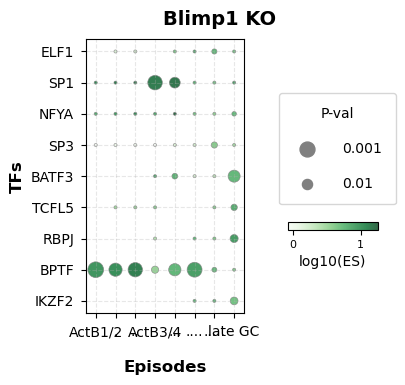

In [25]:
df_ep1 = pd.read_csv(gc_blimp1_ep1)
df_ep2 = pd.read_csv(gc_blimp1_ep2)
df_ep3 = pd.read_csv(gc_blimp1_ep3)
df_ep4 = pd.read_csv(gc_blimp1_ep4)
df_ep5 = pd.read_csv(gc_blimp1_ep5)
df_ep6 = pd.read_csv(gc_blimp1_ep6)
df_ep7 = pd.read_csv(gc_blimp1_ep7)
df_ep8 = pd.read_csv(gc_blimp1_ep8)

fig, plot_data, plotted_tfs = plot_tf_episodic_enrichment_dotplot(
    dfs=[df_ep1, df_ep2, df_ep3, df_ep4, df_ep5, df_ep6, df_ep7, df_ep8],
    episode_labels=['ActB1/2', '.', '..', 'ActB3/4', '...', '....', '.....', 'late GC'],
    figsize=(4.5, 4),
    p_value_threshold=0.05,
    min_significance_threshold=0.05, 
    min_targets_in_lf=2,
    min_targets_dwnstrm=2,
    cmap_name="Greens",
    sort_by_gene_similarity=True,
    show_dendrogram=False,
    figure_title="Blimp1 KO",
    log_scale=True
)
# save the plot
fig.savefig(os.path.join(output_folder, "prdm1_ko_episodic_enrichment_GC.pdf"), dpi=300)
#0.0035 for PB, 0.009 for GC in the gc_pb lf

### Showing the downstream programs regulated by the enriched TFs inside the LF

In [ ]:
def plot_tf_gene_coregulation_heatmap(
    df_ep1, df_ep2, df_ep3, df_ep4,
    episode_labels=['Ep 1', 'Ep 2', 'Ep 3', 'Ep 4'],
    min_tf_episodes=1,
    min_gene_tfs=1,
    figsize=None,
    cmap_name="Blues",
    cluster_genes=True,
    cluster_tfs=True,
    show_values=True,
    value_fontsize=8,
    show_plot=True,
    pathway_labels=None  # Dictionary mapping genes to pathways
):
    """
    Creates a heatmap showing TF-gene co-regulation patterns across episodes with pathway annotations.
    """    
    # Helper function to parse genes
    def parse_genes_in_lf(genes_str):
        try:
            if pd.isna(genes_str) or genes_str == '' or genes_str == '()':
                return set()
            genes_tuple = ast.literal_eval(genes_str)
            return set(genes_tuple) if isinstance(genes_tuple, tuple) else {genes_tuple} if isinstance(genes_tuple, str) else set()
        except:
            return set()
    
    # Collect TF-gene relationships across all episodes
    tf_gene_episodes = {}  # (tf, gene) -> set of episodes
    
    dfs = [df_ep1, df_ep2, df_ep3, df_ep4]
    for ep_idx, (df_ep, ep_label) in enumerate(zip(dfs, episode_labels)):
        if df_ep is None or df_ep.empty:
            continue
            
        df_clean = df_ep.dropna(subset=['TF', 'genes_in_lf'])
        
        for _, row in df_clean.iterrows():
            tf_name = row['TF']
            genes_set = parse_genes_in_lf(row.get('genes_in_lf', ''))
            
            for gene in genes_set:
                key = (tf_name, gene)
                if key not in tf_gene_episodes:
                    tf_gene_episodes[key] = set()
                tf_gene_episodes[key].add(ep_idx)
    
    if not tf_gene_episodes:
        print("No TF-gene relationships found.")
        return None, None, None, None
    
    # Filter TFs and genes based on minimum criteria
    tf_episode_counts = {}
    gene_tf_counts = {}
    
    for (tf, gene), episodes in tf_gene_episodes.items():
        if tf not in tf_episode_counts:
            tf_episode_counts[tf] = set()
        tf_episode_counts[tf].update(episodes)
        
        if gene not in gene_tf_counts:
            gene_tf_counts[gene] = set()
        gene_tf_counts[gene].add(tf)
    
    # Filter TFs and genes
    selected_tfs = [tf for tf, episodes in tf_episode_counts.items() 
                   if len(episodes) >= min_tf_episodes]
    selected_genes = [gene for gene, tfs in gene_tf_counts.items() 
                     if len(tfs) >= min_gene_tfs]
    
    if not selected_tfs or not selected_genes:
        print(f"No TFs or genes meet the filtering criteria")
        return None, None, None, None
    
    # Create TF-gene matrix with episode counts
    tf_gene_matrix = np.zeros((len(selected_tfs), len(selected_genes)))
    
    for i, tf in enumerate(selected_tfs):
        for j, gene in enumerate(selected_genes):
            key = (tf, gene)
            if key in tf_gene_episodes:
                tf_gene_matrix[i, j] = len(tf_gene_episodes[key])
    
    # Process pathway annotations
    pathway_info = None
    if pathway_labels:
        gene_pathways, pathway_color_map, unique_pathways = create_pathway_color_scheme(
            pathway_labels, selected_genes)
        
        pathway_info = {
            'gene_pathways': gene_pathways,
            'pathway_color_map': pathway_color_map,
            'unique_pathways': unique_pathways
        }
    
    # Clustering
    if cluster_tfs and len(selected_tfs) > 1:
        from sklearn.metrics.pairwise import cosine_distances
        try:
            tf_distances = cosine_distances(tf_gene_matrix)
            tf_condensed = squareform(tf_distances)
            tf_linkage = linkage(tf_condensed, method='ward')
            tf_order = leaves_list(tf_linkage)
            selected_tfs = [selected_tfs[i] for i in tf_order]
            tf_gene_matrix = tf_gene_matrix[tf_order, :]
        except Exception as e:
            print(f"TF clustering failed: {e}")

    # Gene clustering by pathway groups
    if cluster_genes and len(selected_genes) > 1:
        if pathway_info:
            # Pathway-based clustering
            print("Clustering genes by pathway groups...")
            
            # Create ordered gene list by pathway
            ordered_genes = []
            for pathway in pathway_info['unique_pathways']:
                # Get genes in this pathway
                genes_in_pathway = [gene for gene in selected_genes 
                                if pathway_info['gene_pathways'][gene] == pathway]
                
                if len(genes_in_pathway) > 1:
                    # Cluster genes within the same pathway
                    try:
                        gene_indices = [selected_genes.index(gene) for gene in genes_in_pathway]
                        pathway_gene_matrix = tf_gene_matrix[:, gene_indices].T
                        
                        gene_distances = cosine_distances(pathway_gene_matrix)
                        gene_condensed = squareform(gene_distances)
                        gene_linkage = linkage(gene_condensed, method='ward')
                        gene_order = leaves_list(gene_linkage)
                        
                        genes_in_pathway = [genes_in_pathway[i] for i in gene_order]
                    except Exception:
                        genes_in_pathway = sorted(genes_in_pathway)
                
                ordered_genes.extend(genes_in_pathway)
            
            # Reorder matrix columns
            gene_reorder_indices = [selected_genes.index(gene) for gene in ordered_genes]
            tf_gene_matrix = tf_gene_matrix[:, gene_reorder_indices]
            selected_genes = ordered_genes
            
            print(f"Genes reordered by {len(pathway_info['unique_pathways'])} pathway groups")
        
        else:
            # Original similarity-based clustering
            try:
                gene_tf_matrix = tf_gene_matrix.T  
                gene_distances = cosine_distances(gene_tf_matrix)
                gene_condensed = squareform(gene_distances)
                gene_linkage = linkage(gene_condensed, method='ward')
                gene_order = leaves_list(gene_linkage)
                selected_genes = [selected_genes[i] for i in gene_order]
                tf_gene_matrix = tf_gene_matrix[:, gene_order]
            except Exception as e:
                print(f"Gene clustering failed: {e}")

    # Update pathway info after reordering
    if pathway_info:
        pathway_info['gene_pathways'] = {gene: pathway_info['gene_pathways'][gene] 
                                    for gene in selected_genes}
    
    # Determine figure size
    if figsize is None:
        fig_width = len(selected_genes) * 0.4 + 3
        fig_height = len(selected_tfs) * 0.3 + 2
        if pathway_info:
            fig_height += 0.3  # Reduced space for thinner pathway annotation
        figsize = (max(8, min(fig_width, 20)), max(6, min(fig_height, 15)))
    
    # Create figure with subplots for pathway annotation
    if pathway_info:
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(2, 1, height_ratios=[0.06, 1], hspace=0.02)  # Thinner pathway bar
        ax_pathway = fig.add_subplot(gs[0])
        ax_main = fig.add_subplot(gs[1])
    else:
        fig, ax_main = plt.subplots(figsize=figsize)
    
    # Plot pathway annotation bar with improved colors
    if pathway_info:
        pathway_colors_ordered = [pathway_info['pathway_color_map'][pathway_info['gene_pathways'][gene]] 
                                for gene in selected_genes]
        
        # Convert hex colors to RGB for imshow
        pathway_colors_rgb = [mcolors.hex2color(color) for color in pathway_colors_ordered]
        pathway_bar = np.array(pathway_colors_rgb).reshape(1, -1, 3)
        
        ax_pathway.imshow(pathway_bar, aspect='auto')
        ax_pathway.set_xlim(-0.5, len(selected_genes) - 0.5)
        ax_pathway.set_xticks([])
        ax_pathway.set_yticks([])
        ax_pathway.set_ylabel("Pathway", fontsize=9, rotation=0, ha='right', va='center')
    
    # Plot main heatmap with proper grid
    im = ax_main.imshow(tf_gene_matrix, cmap=cmap_name, aspect='auto', 
                       vmin=0, vmax=len(episode_labels))
    
    # Add grid lines to create boxes
    ax_main.set_xticks(np.arange(-0.5, len(selected_genes), 1), minor=True)
    ax_main.set_yticks(np.arange(-0.5, len(selected_tfs), 1), minor=True)
    ax_main.grid(which='minor', color='white', linestyle='-', linewidth=1)
    
    # Set ticks and labels
    ax_main.set_xticks(range(len(selected_genes)))
    ax_main.set_xticklabels(selected_genes, rotation=90, ha='center', fontsize=8)
    ax_main.set_xlabel("Target Genes", fontsize=10)
    
    ax_main.set_yticks(range(len(selected_tfs)))
    ax_main.set_yticklabels(selected_tfs, fontsize=8)
    ax_main.set_ylabel("Transcription Factors", fontsize=10)
    
    # Add values to cells
    if show_values:
        for i in range(len(selected_tfs)):
            for j in range(len(selected_genes)):
                value = tf_gene_matrix[i, j]
                if value > 0:
                    text_color = 'white' if value > len(episode_labels)/2 else 'black'
                    ax_main.text(j, i, f'{int(value)}', ha='center', va='center',
                               color=text_color, fontsize=value_fontsize, weight='bold')
    
    # Horizontal Colorbar at bottom
    cbar = plt.colorbar(im, ax=ax_main, orientation='horizontal', 
                    fraction=0.05, pad=0.1, shrink=0.6, aspect=30)
    cbar.set_label('Number of Episodes', fontsize=10)
    cbar.set_ticks(range(len(episode_labels) + 1))
    
    # Add pathway legend in middle right
    if pathway_info:
        legend_elements = []
        for pathway in pathway_info['unique_pathways']:
            color = pathway_info['pathway_color_map'][pathway]
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color, label=pathway))
        
        # Position legend in middle right
        legend = ax_main.legend(handles=legend_elements, loc='center left', 
                            bbox_to_anchor=(1.02, 0.5),  # Middle right
                            fontsize=7, frameon=False, ncol=1)
        
        # Adjust legend to not overlap with horizontal colorbar
        legend.set_bbox_to_anchor((1.02, 0.65))  # Move up slightly to avoid colorbar

    # Title
    title = f'TF-Gene Co-regulation Across Episodes\n({len(selected_tfs)} TFs, {len(selected_genes)} genes)'
    if pathway_info:
        title += f', {len(pathway_info["unique_pathways"])} pathways'
    ax_main.set_title(title, fontsize=12, pad=20)
    
    # Set limits
    ax_main.set_xlim(-0.5, len(selected_genes) - 0.5)
    ax_main.set_ylim(-0.5, len(selected_tfs) - 0.5)
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    # Return summary dataframe
    summary_data = []
    for i, tf in enumerate(selected_tfs):
        for j, gene in enumerate(selected_genes):
            episodes_count = tf_gene_matrix[i, j]
            if episodes_count > 0:
                pathway = pathway_info['gene_pathways'][gene] if pathway_info else "Unknown"
                summary_data.append({
                    'TF': tf,
                    'Gene': gene, 
                    'Episodes_Count': int(episodes_count),
                    'Pathway': pathway
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print summary
    print(f"\nPlot Summary:")
    print(f"- {len(selected_tfs)} TFs included")
    print(f"- {len(selected_genes)} target genes included")
    if pathway_info:
        print(f"- {len(pathway_info['unique_pathways'])} pathway categories")
    print(f"- Total TF-gene relationships: {len(summary_data)}")
    
    return fig, summary_df, selected_genes, selected_tfs

In [ ]:
df_ep1 = pd.read_csv(pb_ep1)
df_ep2 = pd.read_csv(pb_ep2)
df_ep3 = pd.read_csv(pb_ep3)
df_ep4 = pd.read_csv(pb_ep4)

fig, summary_df, target_genes, tfs_included = plot_tf_gene_coregulation_heatmap(
    df_ep1, df_ep2, df_ep3, df_ep4,
    min_tf_episodes=2,  
    min_gene_tfs=1,     
    cluster_genes=True,
    cluster_tfs=True,
    show_values=True,
    pathway_labels=pathway_labels  # Use the pathway dictionary
)

In [ ]:
display(summary_df)
# save summary_df to csv
summary_df.to_csv(os.path.join(input_folder, 'enriched_links_pathways_pb.csv'), index=False)